# STEP 1 – Pre-processing : noise and outliers removal

We want to define a region of interest (ROI) that has an homogeneous density. We will use an intensity filter to remove most of the noise, and then re-export our file to do step 2 on CloudCompare, using CANUPO plugin.

In [1]:
import laspy
import numpy as np
import matplotlib.pyplot as plt

Let's import our data as a .las file. As we get its metadata, apparently there are only coordinates and intensity in the input file, that is to say a matrix of n by 4, n being the number of points. There is also for each coordinate the scale to apply to get the real size of the data, as the las file rescales it to only get integers. We should store this scale.

In [2]:
file = '2023-05-17_08-14-07_10pct.las' #to modify for each use

In [3]:
path = '1-your_initial_data/' 
path1 = path + file

print('please insure that the file is located in the following folder:', path)

please insure that the file is located in the following folder: 1-your_initial_data/


In [4]:
cloud = laspy.read(path1)

print('parameters available from this las file :', list(cloud.point_format.dimension_names))

scale = cloud.header.scales

x , y , z = cloud.X*scale[0] , cloud.Y*scale[1] , cloud.Z*scale[2]
x , y , z = x.reshape(len(x),1) , y.reshape(len(y),1) , z.reshape(len(z),1)

intensity = cloud.intensity.reshape(len(x),1)

CLOUD = np.hstack([x,y,z,intensity])

n , n_param = CLOUD.shape


print('')
print(file,'contains',n,'points and',n_param,'active parameters')

parameters available from this las file : ['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'red', 'green', 'blue']

2023-05-17_08-14-07_10pct.las contains 8073053 points and 4 active parameters


Let's visualize the point cloud to see if we should calibrate its size.

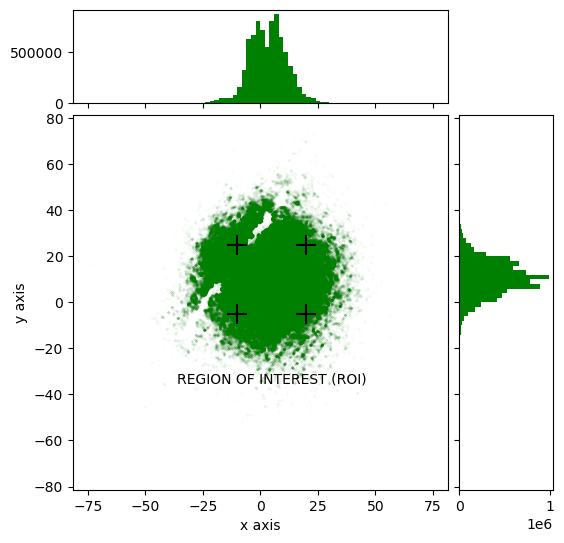

In [5]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, c): #source : matplotlib documentation
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y,s=0.05,alpha=0.1,c=c)

    # now determine nice limits by hand:
    binwidth = 2
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins,color=c)
    ax_histy.hist(y, bins=bins, orientation='horizontal',color=c)



#plotting the cloud using our function defined above   
fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
plt.xlabel('x axis')
plt.ylabel('y axis')
ax_x = fig.add_subplot(gs[0, 0],sharex=ax)
ax_y = fig.add_subplot(gs[1, 1],sharey=ax)
scatter_hist(x, y, ax, ax_x, ax_y,'g')


#defining the ROI in the (x,y) plan
ROIxmax = 20
ROIxmin = -10
ROIymax = 25
ROIymin = -5
center = (ROIxmax+ROIxmin)/2 , (ROIymax+ROIymin)/2

ax.scatter([ROIxmin,ROIxmin,ROIxmax,ROIxmax],[ROIymin,ROIymax,ROIymin,ROIymax],marker='+',s=200,c='k')

ax.text(center[0],center[1]-45,'REGION OF INTEREST (ROI)',ha='center',c='k',weight='medium',size=10)


plt.show()

We then calibrate the plot to select only the most dense part. Indeed, DBScan, that we will use later to cluster the trees, needs to have clusters of even density to be efficient. HDBScan would eventually handle this issue, but is more likely to select shrubs and lower vegetation that we don't want to cluster. We verify then that there are no apparent outliers.

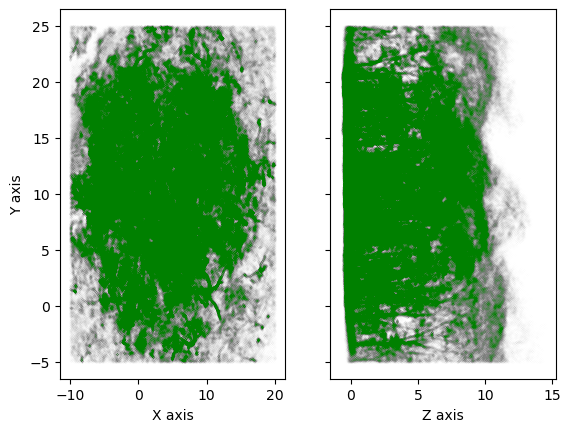

In [6]:
CLOUD = CLOUD[CLOUD[:,0]>=ROIxmin]
CLOUD = CLOUD[CLOUD[:,0]<=ROIxmax]
CLOUD = CLOUD[CLOUD[:,1]>=ROIymin]
CLOUD = CLOUD[CLOUD[:,1]<=ROIymax]

extented_ROI = CLOUD #to save this version for later

plt.subplots(1,2,sharey=True)

plt.subplot(1,2,1)
plt.scatter(CLOUD[:,0],CLOUD[:,1],s=0.05,alpha=0.01,c='g')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.subplot(1,2,2)
plt.scatter(CLOUD[:,2],CLOUD[:,1],s=0.05,alpha=0.01,c='g')
plt.xlabel('Z axis')
plt.show()

Let's check if we kept most of the points in our ROI (>80 % should be great).

In [7]:
print('percentage of points in the ROI:',np.round(100*len(extented_ROI)/n,2),'%')

percentage of points in the ROI: 89.41 %


We now want to use an intensity filter. We will try one filtering of the whole cloud, and two other with vertical slices.

slice 1 reducted to 5.17 % of the initial file
slice 2 reducted to 4.97 % of the initial file
slice 3 reducted to 4.78 % of the initial file
slice 4 reducted to 4.49 % of the initial file
slice 5 reducted to 4.7 % of the initial file
slice 6 reducted to 4.22 % of the initial file
slice 7 reducted to 4.68 % of the initial file
slice 8 reducted to 4.78 % of the initial file
slice 9 reducted to 4.47 % of the initial file


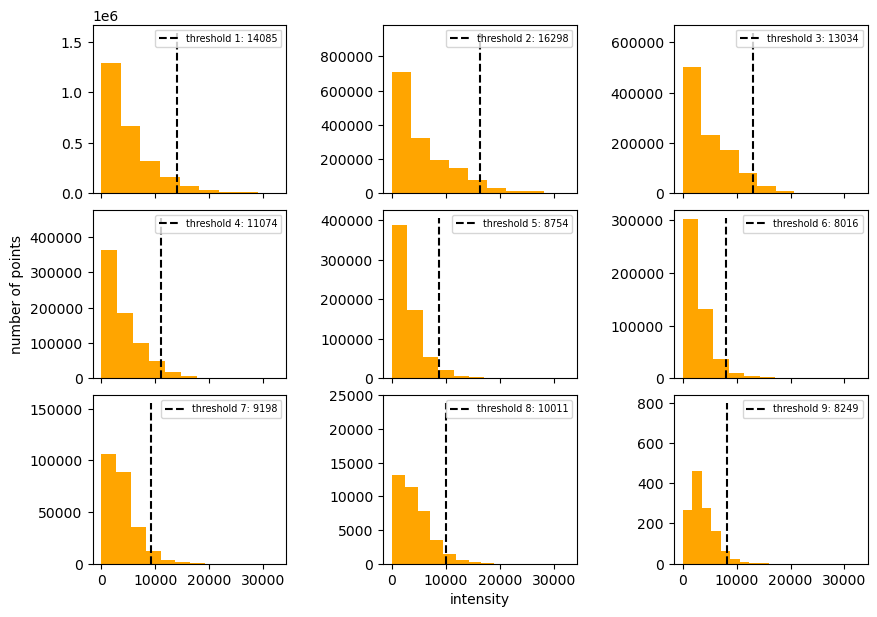

In [8]:
plt.subplots(3,3,sharex = True, sharey = False,figsize=(10,7))
plt.subplots_adjust(wspace=0.5,hspace=0.1)

n_it = 9
slices = np.linspace(CLOUD[:,2].min(),CLOUD[:,2].max(),n_it+1)

F_CLOUD = np.zeros((0,4))


#for this slicing we will plot histograms showing the repartition of the points following their intensity
for i in range ( n_it ) :
    plt.subplot(3,3,i+1)
    low , high = slices[i] , slices[i+1]
    slc = CLOUD[CLOUD[:,2]>=low]
    slc = slc[slc[:,2]<high]
    if len(slc)>0:
        plt.hist(slc[:,3],bins=np.linspace(0,slc[:,3].max(),10),color='orange')
        plt.vlines(slc[:,3].mean()+2*slc[:,3].std(),0,len(slc)/1.6,colors='k',linestyle='--',
                   label = f'threshold {i+1}: {int(slc[:,3].mean()+2*slc[:,3].std())}')
        plt.legend(fontsize='x-small')
        if i+1==8:
            plt.xlabel('intensity')
        if i+1==4:    
            plt.ylabel('number of points')
        initial = len(slc)
        slc = slc[slc[:,3]>=slc[:,3].mean()+2*slc[:,3].std()]
        final = len(slc)
        F_CLOUD = np.vstack([F_CLOUD,slc])
        print('slice',i+1,'reducted to',np.round(100*final/initial,2),'% of the initial file')


plt.show()

In [9]:
n_it_2 = 50
slices = np.linspace(CLOUD[:,2].min(),CLOUD[:,2].max(),n_it_2+1)

F_CLOUD_2 = np.zeros((0,4))

for i in range ( n_it_2 ) :
    low , high = slices[i] , slices[i+1]
    slc = CLOUD[CLOUD[:,2]>=low]
    slc = slc[slc[:,2]<high]
    if len(slc)>0:
        initial = len(slc)
        slc = slc[slc[:,3]>=slc[:,3].mean()+2*slc[:,3].std()]
        final = len(slc)
        F_CLOUD_2 = np.vstack([F_CLOUD_2,slc])
        print('slice',i+1,'reducted to',np.round(100*final/initial,2),'% of the initial file')

slice 1 reducted to 4.98 % of the initial file
slice 2 reducted to 4.75 % of the initial file
slice 3 reducted to 5.14 % of the initial file
slice 4 reducted to 5.31 % of the initial file
slice 5 reducted to 5.55 % of the initial file
slice 6 reducted to 5.62 % of the initial file
slice 7 reducted to 5.65 % of the initial file
slice 8 reducted to 5.07 % of the initial file
slice 9 reducted to 5.08 % of the initial file
slice 10 reducted to 4.61 % of the initial file
slice 11 reducted to 4.45 % of the initial file
slice 12 reducted to 4.39 % of the initial file
slice 13 reducted to 4.64 % of the initial file
slice 14 reducted to 4.39 % of the initial file
slice 15 reducted to 4.46 % of the initial file
slice 16 reducted to 4.69 % of the initial file
slice 17 reducted to 5.37 % of the initial file
slice 18 reducted to 4.73 % of the initial file
slice 19 reducted to 4.86 % of the initial file
slice 20 reducted to 4.26 % of the initial file
slice 21 reducted to 4.8 % of the initial file
sl

In [10]:
mean_int = CLOUD[:,3].mean()
std_int = CLOUD[:,3].std()
int_threshold = mean_int + 2.5*std_int #arbitrary

print('intensity filter set with a threshold of',int_threshold)

CLOUD = CLOUD[CLOUD[:,3]>=int_threshold]

intensity filter set with a threshold of 15550.16125693603


We can now assess our three methods by quantifying the number of points removed, and by plotting the resulting spatial repartition. 

In [11]:
print('there are now',len(CLOUD),f'points left ({np.round(len(CLOUD)*100/n,2)} % of the initial set)')
print('there are now',len(F_CLOUD),f'points left ({np.round(len(F_CLOUD)*100/n,2)} % of the initial set)')
print('there are now',len(F_CLOUD_2),f'points left ({np.round(len(F_CLOUD_2)*100/n,2)} % of the initial set)')

there are now 210243 points left (2.6 % of the initial set)
there are now 352210 points left (4.36 % of the initial set)
there are now 351090 points left (4.35 % of the initial set)


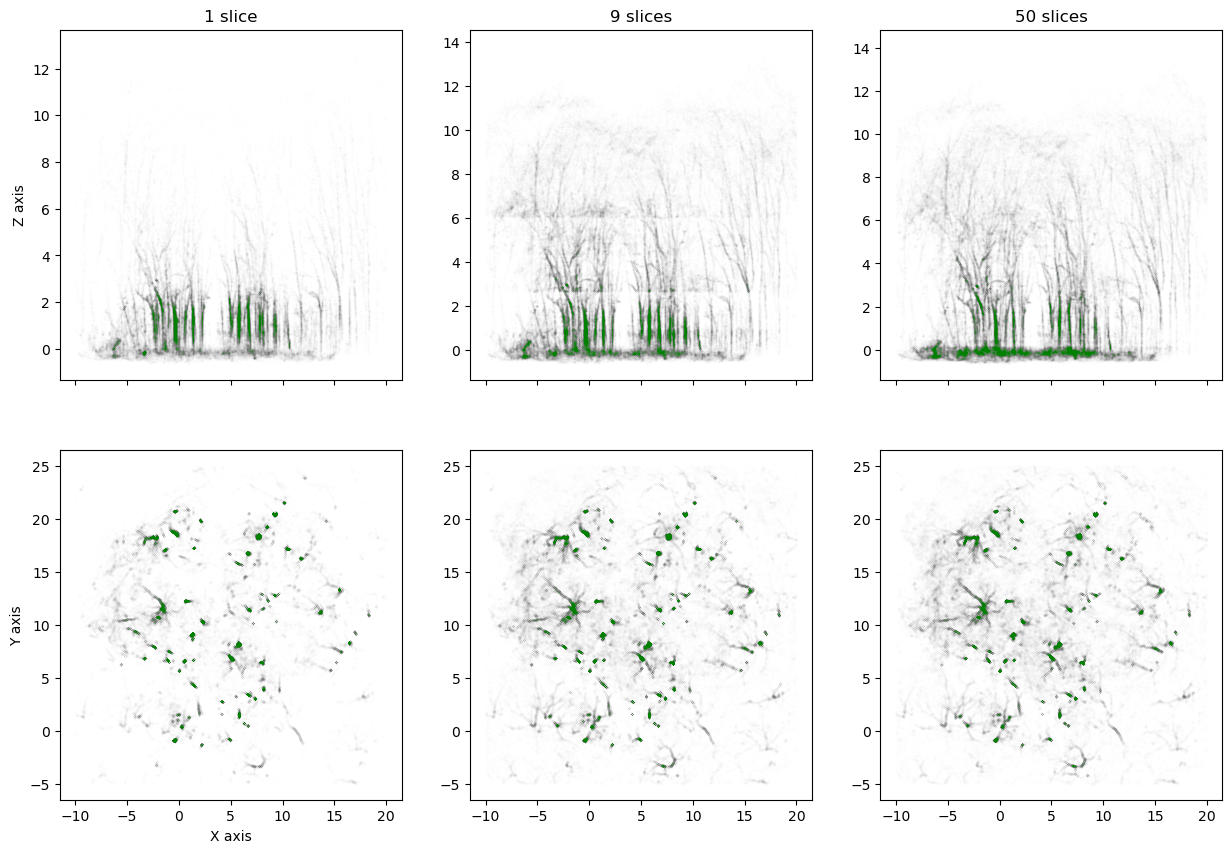

In [12]:
plt.subplots(2,3,sharex=True,figsize=(15,10))
plt.subplots_adjust(hspace=0.2)

plt.subplot(2,3,1)
plt.title(f'1 slice')
plt.scatter(CLOUD[:,0],CLOUD[:,2],s=0.1,alpha=0.01,c='g')
plt.ylabel('Z axis')
plt.subplot(2,3,4)
plt.scatter(CLOUD[:,0],CLOUD[:,1],s=0.05,alpha=0.01,c='g')
plt.ylabel('Y axis')
plt.xlabel('X axis')

plt.subplot(2,3,2)
plt.title(f'{n_it} slices')
plt.scatter(F_CLOUD[:,0],F_CLOUD[:,2],s=0.1,alpha=0.01,c='g')
plt.subplot(2,3,5)
plt.scatter(F_CLOUD[:,0],F_CLOUD[:,1],s=0.05,alpha=0.01,c='g')



plt.subplot(2,3,3)
plt.title(f'{n_it_2} slices')
plt.scatter(F_CLOUD_2[:,0],F_CLOUD_2[:,2],s=0.1,alpha=0.01,c='g')
plt.subplot(2,3,6)
plt.scatter(F_CLOUD_2[:,0],F_CLOUD_2[:,1],s=0.05,alpha=0.01,c='g')

plt.show()

It appears to be clear that the most sliced cloud keeps the most details while removing most of the noise. Let's keep it and export it to classify it in CloudCompare (vegetation/ground differentiation).

In [13]:
CLOUD = F_CLOUD_2

path2 = '2-intensity_filtered_point_cloud/' #please insure that this folder exists in your local environment

output_file = laspy.LasData(laspy.LasHeader(version="1.2"))
output_file.x = CLOUD[:,0]
output_file.y = CLOUD[:,1]
output_file.z = CLOUD[:,2]
output_file.intensity = CLOUD[:,3]
output_file.write(path2+f"{file}_ROI.las")

## Function format of step 1

In [1]:
def 強度過濾(文件,幾片,ROI):
    
    import laspy
    import numpy as np
    import matplotlib.pyplot as plt
    import time
    
    init_time = time.time()
    
    path = '1-your_initial_data/' 
    path1 = path + 文件
    
    cloud = laspy.read(path1)

    scale = cloud.header.scales

    x , y , z = cloud.X*scale[0] , cloud.Y*scale[1] , cloud.Z*scale[2]
    x , y , z = x.reshape(len(x),1) , y.reshape(len(y),1) , z.reshape(len(z),1)

    intensity = cloud.intensity.reshape(len(x),1)

    CLOUD = np.hstack([x,y,z,intensity])

    n , n_param = CLOUD.shape


    print('')
    print(文件,'中有',n,'點',n_param,'參數')
    
    
    def scatter_hist(x, y, ax, ax_histx, ax_histy, c): #source : matplotlib documentation
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)
        ax.scatter(x, y,s=0.05,alpha=0.1,c=c)
        binwidth = 2
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        bins = np.arange(-lim, lim + binwidth, binwidth)
        ax_histx.hist(x, bins=bins,color=c)
        ax_histy.hist(y, bins=bins, orientation='horizontal',color=c)

    fig = plt.figure(figsize=(6,6))
    gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1, 0])
    plt.xlabel('x axis')
    plt.ylabel('y axis')
    ax_x = fig.add_subplot(gs[0, 0],sharex=ax)
    ax_y = fig.add_subplot(gs[1, 1],sharey=ax)
    scatter_hist(x, y, ax, ax_x, ax_y,'g')


    #defining the ROI in the (x,y) plan
    ROIxmax = ROI[1]
    ROIxmin = ROI[0]
    ROIymax = ROI[3]
    ROIymin = ROI[2]
    center = (ROIxmax+ROIxmin)/2 , (ROIymax+ROIymin)/2

    ax.scatter([ROIxmin,ROIxmin,ROIxmax,ROIxmax],[ROIymin,ROIymax,ROIymin,ROIymax],marker='+',s=200,c='k')

    plt.show()
    
    
    CLOUD = CLOUD[CLOUD[:,0]>=ROIxmin]
    CLOUD = CLOUD[CLOUD[:,0]<=ROIxmax]
    CLOUD = CLOUD[CLOUD[:,1]>=ROIymin]
    CLOUD = CLOUD[CLOUD[:,1]<=ROIymax]

    plt.subplots(1,2,sharey=True)
    plt.subplot(1,2,1)
    plt.scatter(CLOUD[:,0],CLOUD[:,1],s=0.05,alpha=0.01,c='g')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.subplot(1,2,2)
    plt.scatter(CLOUD[:,2],CLOUD[:,1],s=0.05,alpha=0.01,c='g')
    plt.xlabel('Z axis')
    plt.show()
    
    print('在ROI中的點:',np.round(100*len(CLOUD)/n,2),'百分之')
    

    slices = np.linspace(CLOUD[:,2].min(),CLOUD[:,2].max(),幾片+1)

    F_CLOUD = np.zeros((0,4))

    #for this slicing we will plot histograms showing the repartition of the points following their intensity
    for i in range ( 幾片 ) :
        low , high = slices[i] , slices[i+1]
        slc = CLOUD[CLOUD[:,2]>=low]
        slc = slc[slc[:,2]<high]
        if len(slc)>0:
            initial = len(slc)
            slc = slc[slc[:,3]>=slc[:,3].mean()+2*slc[:,3].std()]
            final = len(slc)
            F_CLOUD = np.vstack([F_CLOUD,slc])
            print('第',i+1,'片，現在剩初始的',np.round(100*final/initial,2),'百分之')

    print('現在有',len(F_CLOUD),f'個剩點 (初始的 {np.round(len(F_CLOUD)*100/n,2)} 百分之)')
    
    plt.subplots(2,1,sharex=True,figsize=(5,10))
    plt.subplot(2,1,1)
    plt.title(f'{幾片} slices')
    plt.scatter(F_CLOUD[:,0],F_CLOUD[:,2],s=0.1,alpha=0.01,c='g')
    plt.ylabel('Z axis')
    plt.subplot(2,1,2)
    plt.scatter(F_CLOUD[:,0],F_CLOUD[:,1],s=0.05,alpha=0.01,c='g')
    plt.ylabel('Y axis')
    plt.xlabel('X axis')

    plt.show()
    
    path2 = '2-intensity_filtered_point_cloud/'

    output_file = laspy.LasData(laspy.LasHeader(version="1.2"))
    output_file.x = F_CLOUD[:,0]
    output_file.y = F_CLOUD[:,1]
    output_file.z = F_CLOUD[:,2]
    output_file.intensity = F_CLOUD[:,3]
    output_file.write(path2+f"{文件[:-4]}_ROI.las")
    
    time = time.time() - init_time
    
    return print(f'都好了，花了{np.round(time,2)} sec')
    